# **Prediction of Anosognosia in right stroke patients with hemiplegia from lesion data**

we have FMRI image data and Excel consist ('ID', 'Lesion_size', 'Age', 'Anosognosia')

1. flag the data which is not aligned with other images
2. reshape all images to (91, 109, 91) MNI standard
3. pre processing: feature selection and reduce dimension with PCA to explain 90% of variances
4. find AUC and ROC curve
5. find the most potent component according to the highest weight

Data from Pacella et al., 2019, eLife
This was the train project in the Machin learning class taught by Professor Marco Zorzi


In [26]:
# import necessary libraries
!pip install nilearn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeCV
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve
from nilearn import plotting
from nibabel import processing
from nilearn.image import resample_img, smooth_img, threshold_img
import os
from sklearn.preprocessing import StandardScaler


In [2]:
!unzip /content/Lesion_images.zip -d /content/

Archive:  /content/Lesion_images.zip
   creating: /content/Lesion_images/
  inflating: /content/Lesion_images/AhpD__A8.nii.gz  
  inflating: /content/Lesion_images/AhpD__B16.nii.gz  
  inflating: /content/Lesion_images/AhpD__B18.nii.gz  
  inflating: /content/Lesion_images/AhpD__B19.nii.gz  
  inflating: /content/Lesion_images/AhpD__B20.nii.gz  
  inflating: /content/Lesion_images/AhpD__B26.nii.gz  
  inflating: /content/Lesion_images/AhpD__B28.nii.gz  
  inflating: /content/Lesion_images/AhpD__C10.nii.gz  
  inflating: /content/Lesion_images/AhpD__C12.nii.gz  
  inflating: /content/Lesion_images/AhpD__C13.nii.gz  
  inflating: /content/Lesion_images/AhpD__C7.nii.gz  
  inflating: /content/Lesion_images/AhpD__C8.nii.gz  
  inflating: /content/Lesion_images/AhpD__C9.nii.gz  
  inflating: /content/Lesion_images/Ahp__A1.nii.gz  
  inflating: /content/Lesion_images/Ahp__A3.nii.gz  
  inflating: /content/Lesion_images/Ahp__A4.nii.gz  
  inflating: /content/Lesion_images/Ahp__A5.nii.gz  
  i

In [3]:
# set paths
lesions_fname = '/content/Lesions_images'
data_fname = '/content/patients_data.xlsx'

In [7]:
df = pd.read_excel('/content/patients_data.xlsx')
print(df.columns)
y=df['Anosognosia']
print(y)

Index(['ID', 'Lesion_size', 'Age', 'Anosognosia'], dtype='object')
0      1
1      1
2      1
3      1
4      1
      ..
169    0
170    0
171    0
172    0
173    0
Name: Anosognosia, Length: 174, dtype: int64


Count patient with Anosognosia, which is 95 according to the output

In [9]:
patient_anosognosia=0
for i in df['Anosognosia']:
  if i==1:
    patient_anosognosia+=1
print(patient_anosognosia)
df.head()

95


,ID,Lesion_size,Age,Anosognosia
0,Ahp__A1.nii.gz,17959,68,1
1,Ahp__A3.nii.gz,194775,65,1
2,Ahp__A4.nii.gz,15888,82,1
3,Ahp__A5.nii.gz,117217,67,1
4,Ahp__A6.nii.gz,238261,76,1


read the data and remove this image from our data 'Ahp__D1.nii.gz'

In [ ]:
df = pd.read_excel('/content/patients_data.xlsx')
df = data[data['ID'] != 'Ahp__D1.nii.gz']
df=data.reset_index(drop=True)

The affine matrix is a 4x4 matrix that maps the coordinates of the image from voxel space to real-world space (like millimeters). It defines how the 3D image is "positioned" in space relative to a standard coordinate system (like MNI space).

**('L', 'A', 'S')** stands for:
L: Left-to-right (the first dimension)
A: Anterior-to-posterior (the second dimension)
S: Superior-to-inferior (the third dimension)

With Raise function we want to flag data that are not like other images in terms of size or position

we want to reshape all images to the  **91, 109,91**  This shape corresponds to the standard MNI space used in
neuroimaging (also known as MNI152 template space).

In [18]:
# read lesion volumes with nibabel and reshape as 1D array and save in a list
lesions = []
for f in df.ID:
  # read lesion
  lesion = nib.load(f'/content/Lesion_images/{f}')
  if lesion.shape != (182, 218, 182) or nib.aff2axcodes(lesion.affine) != ('L', 'A', 'S'):
    raise ValueError(f'Shape or orientation mismatch for {f}')

  # resample to 91, 109, 91 (from 1 mm to 2 mm resolution)
  new_affine = np.copy(lesion.affine)
  new_affine[:3, :3] *= 2
  lesion = resample_img(lesion,
                        target_affine=new_affine,
                        target_shape=(91, 109, 91),
                        interpolation='nearest',
                        copy_header=True,
                        force_resample=True)
  # convert to numpy array
  lesion = lesion.get_fdata()
  if lesion.min() < 0 or lesion.max() > 1:
    raise ValueError(f'Values out of range for {f}')

  lesions.append(lesion.reshape(-1))

# stack each array into N (patients) x M (voxels) matrix
lesions = np.vstack(lesions)
print(f'Lesions shape: {lesions.shape}')

Lesions shape: (173, 902629)


Plot arbitrary patient brain lesion, for example, number 3

Plotting lesion of patient Ahp__A5.nii.gz


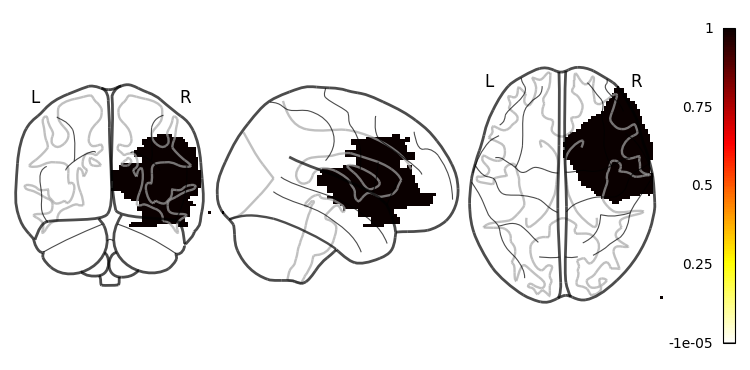

In [19]:
lesion_index = 3
print(f'Plotting lesion of patient {df.loc[lesion_index, "ID"]}')
lesion_img = nib.Nifti1Image(lesions[lesion_index].reshape(91, 109, 91), new_affine)
_ = plotting.plot_glass_brain(lesion_img, colorbar=True)

# **Preprocessing: PCA**

with PCA 90% we can 173 patient and 72 feature and variable that will be the input of our classifier and thats still a lot so we need regulirization

In [21]:
pca=PCA(n_components=0.90)
lesions_pca=pca.fit_transform(lesions)
print(f'PCA shape: {lesions_pca.shape}')

PCA shape: (173, 72)


plot the explained_variance as a function of PCs

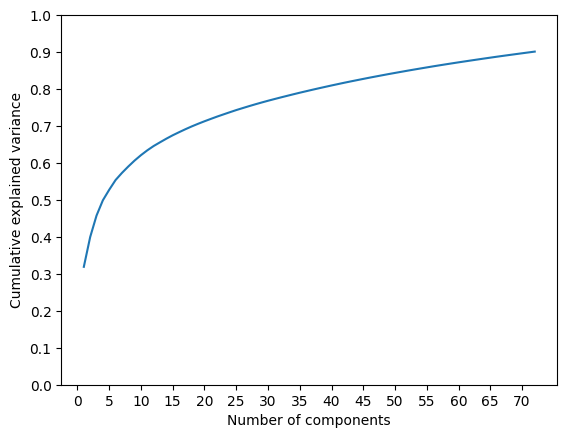

In [24]:
plt.plot(range(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.xticks(np.arange(0, lesions_pca.shape[1], 5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

AUC= 0.62 is not really high. Maybe we can change our PCA to have a higher AUC

In [28]:
# Predict anosognosia
x = lesions_pca
y = df['Anosognosia']

# define the outer loop of a nested cross validation
outer_kf = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)

# create empty array to save the predictions
y_pred = np.array([np.nan] * len(y))
weights = []
for train_index, test_index in outer_kf.split(x, y):

  # split data into training and test fold
  x_train, x_test = np.copy(x[train_index]), np.copy(x[test_index])
  y_train, y_test = y[train_index], y[test_index]
  #stardarize
  sc = StandardScaler()
  x_train = sc.fit_transform(x_train)
  x_test = sc.transform(x_test)

  # define model
  model = LogisticRegressionCV(Cs=10,
                               fit_intercept=True,
                               penalty='l2',
                               cv=10,
                               tol=1e-4,
                               max_iter=1000,
                               class_weight='balanced')

  # tune the penalty parameter and fit the model on the entire training set
  model.fit(x_train, y_train)

 # save the learnt weights
  weights.append(model.coef_)

  # predict the test set
  y_pred[test_index] = model.predict_proba(x_test)[:, 1]

# compute AUC
roc_auc = roc_auc_score(y, y_pred)
print(f'AUC: {roc_auc:.3f}')
# summarise the weights
weights = np.median(np.array(weights), axis=0).reshape(-1)


AUC: 0.624


# **Plot ROC**

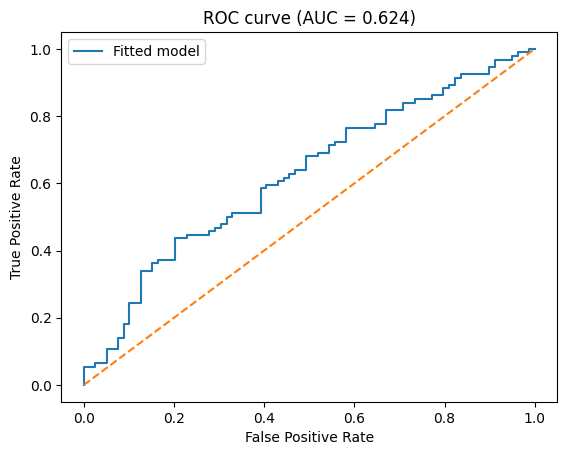

In [29]:
fpr, tpr, thresholds = roc_curve(y, y_pred)
plt.plot(fpr, tpr, label='Fitted model')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC curve (AUC = {roc_auc:.3f})')
plt.legend()
plt.show()

lets check most powerful and important component which has more weigh compare to others,

retrieve the (n) PCs with the largest positive weights and plot the loadings of each PC with nilearn stat map

from the output we know that component 8 with 0.93 weight has more weight and is more important and can predict better

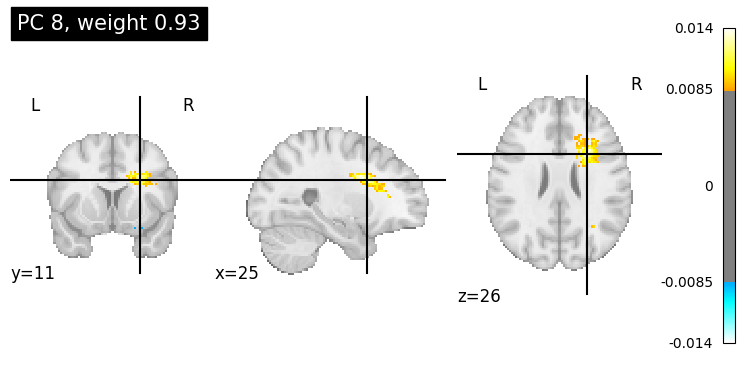

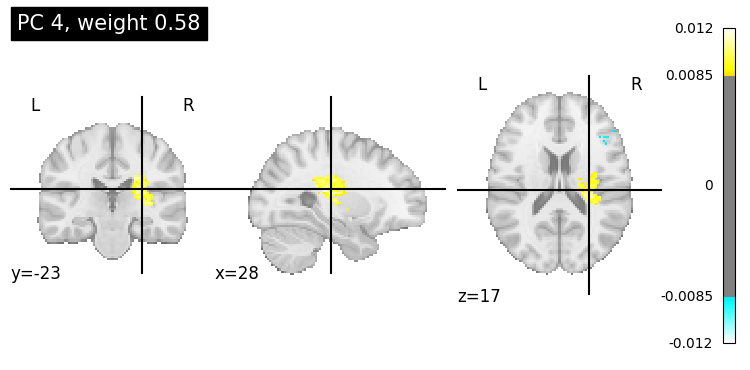

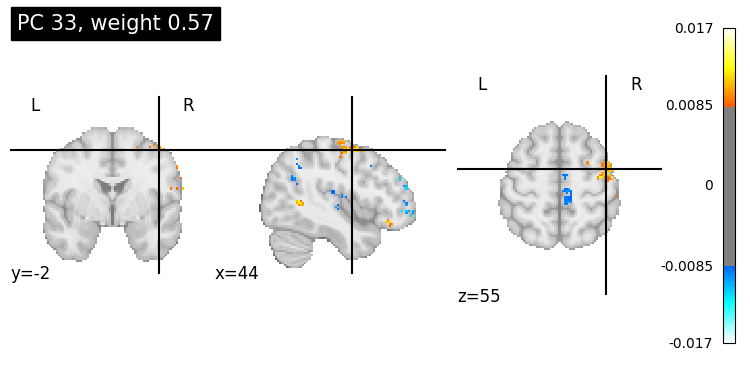

In [31]:
n = 3
idx = np.argsort((weights))[-n:]
for pc in reversed(idx):
  loadings = pca.components_[pc]
  loadings = loadings.reshape(91, 109, 91)
  loadings = nib.Nifti1Image(loadings, new_affine)
  _ = plotting.plot_stat_map(loadings,
                             colorbar=True,
                             title=f'PC {pc}, weight {weights[pc]:.2f}',
                             threshold=0.0085)